In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm

# --- 1. Configuration and Hyperparameters ---
IMG_SIZE = 28
BATCH_SIZE = 128
NUM_EPOCHS = 50 
LEARNING_RATE = 1e-3
TIMESTEPS = 1000
DEVICE = "cuda:4"


/raid/home/chandanj/miniconda3/envs/raghava/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- 2. U-Net Architecture (Denoising Network) ---

class ConvBlock(nn.Module):
    """
    A basic convolutional block that:
      1) Applies two 3×3 convolutions (with BatchNorm + ReLU)
      2) Injects a time-step embedding as a per-channel bias between them
    """
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        # MLP to project the time embedding into a bias vector of size out_channels
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        # First conv layer: from in_channels to out_channels, 3×3 with padding
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        # Second conv layer: maintains out_channels
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        # BatchNorm layers to stabilize training after each conv
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, x, t_emb):
        # x: [B, in_channels, H, W], t_emb: [B, time_emb_dim]
        # 1) Conv → ReLU → BatchNorm
        h = self.bn1(self.relu(self.conv1(x)))
        # 2) Project time embedding → [B, out_channels]
        time_emb = self.relu(self.time_mlp(t_emb))
        # 3) Reshape to [B, out_channels, 1, 1] so it can broadcast spatially
        time_emb = time_emb[(...,) + (None,) * 2]
        # 4) Add time bias to conv features
        h = h + time_emb
        # 5) Second Conv → ReLU → BatchNorm
        h = self.bn2(self.relu(self.conv2(h)))
        return h


class UNet(nn.Module):
    """
    A U-Net that incorporates time conditioning.  Instead of predicting noise,
    this version directly predicts the clean image x₀.
    """
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=256):
        super().__init__()
        # MLP to refine the sinusoidal time encoding before feeding into ConvBlocks
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # Encoder (downsampling) path
        self.inc   = ConvBlock(in_channels, 64,  time_emb_dim)  # initial block
        self.down1 = ConvBlock(64,           128, time_emb_dim)
        self.down2 = ConvBlock(128,          256, time_emb_dim)
        self.downsample = nn.MaxPool2d(2)  # half spatial dims

        # Bottleneck: two ConvBlocks at the lowest resolution
        self.bot1 = ConvBlock(256, 256, time_emb_dim)
        self.bot2 = ConvBlock(256, 256, time_emb_dim)

        # Decoder (upsampling) path
        # Each up block concatenates skip connection from the encoder
        self.up1 = ConvBlock(256 + 128, 128, time_emb_dim)
        self.up2 = ConvBlock(128 + 64,   64,  time_emb_dim)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Final 1×1 conv to map back to the desired number of channels (clean image x₀)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)

    def pos_encoding(self, t, dim):
        """
        Compute sinusoidal embeddings for timesteps t:
          - inv_freq: frequencies for sin/cos
          - pos_emb_sin/cos: [B, dim/2] each → concatenated to [B, dim]
        """
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        inv_freq = inv_freq.to(t.device)
        pos_emb_sin = torch.sin(t.float().unsqueeze(1) * inv_freq)
        pos_emb_cos = torch.cos(t.float().unsqueeze(1) * inv_freq)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb

    def forward(self, x, t):
        """
        x: noisy image [B,1,H,W], t: timestep tensor [B]
        Returns the network's estimate of the clean image x₀.
        """
        # 1) Build time embedding: sinusoidal → MLP
        t_emb = self.time_mlp(self.pos_encoding(t, self.time_mlp[0].in_features))

        # --- Encoder ---
        x1 = self.inc(x, t_emb)                   # [B,  64, H, W]
        x2 = self.down1(self.downsample(x1), t_emb)  # [B, 128, H/2, W/2]
        x3 = self.down2(self.downsample(x2), t_emb)  # [B, 256, H/4, W/4]

        # --- Bottleneck ---
        x_bot = self.bot1(x3, t_emb)                # [B, 256, H/4, W/4]
        x_bot = self.bot2(x_bot, t_emb)             # [B, 256, H/4, W/4]

        # --- Decoder ---
        x_up1     = self.upsample(x_bot)            # [B,256,H/2,W/2]
        x_concat1 = torch.cat([x_up1, x2], dim=1)   # skip connection
        x_dec1    = self.up1(x_concat1, t_emb)      # [B,128,H/2,W/2]

        x_up2     = self.upsample(x_dec1)           # [B,128,H,W]
        x_concat2 = torch.cat([x_up2, x1], dim=1)   # skip connection
        x_dec2    = self.up2(x_concat2, t_emb)      # [B, 64, H, W]

        # --- Output: predicted clean image x₀ ---
        predicted_x0 = self.outc(x_dec2)            # [B,1,H,W]
        return predicted_x0

In [3]:
# --- 3. DDPM Class (modified for x₀ estimation) ---
class DDPM(nn.Module):
    def __init__(self, model, timesteps=1000,
                 beta_start=0.0001, beta_end=0.02,
                 device=DEVICE):
        super().__init__()
        # The U-Net (or other backbone) now predicts x₀ directly
        self.model      = model.to(device)
        # Total diffusion steps
        self.timesteps  = timesteps
        # Device for tensors
        self.device     = device

        # 1) Linear noise schedule β₁…β_T
        self.betas      = torch.linspace(beta_start, beta_end, timesteps).to(device)
        # 2) Signal coefficients α_t = 1 − β_t
        self.alphas     = 1.0 - self.betas
        # 3) Cumulative product ᾱ_t = ∏_{s=1}^t α_s
        self.alphas_cumprod      = torch.cumprod(self.alphas, axis=0)
        # 4) ᾱ_{t-1}, padded so that ᾱ₀ = 1
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        # 5) Precompute √ᾱ_t and √(1 − ᾱ_t) for forward sampling
        self.sqrt_alphas_cumprod          = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

        # 6) Analytical posterior variance Var[q(x_{t-1} | x_t, x₀)]
        self.posterior_variance = (
            self.betas
            * (1. - self.alphas_cumprod_prev)
            / (1. - self.alphas_cumprod)
        )
        
    def forward_diffusion(self, x_0, t, noise=None):
        """
        q(x_t | x₀): Corrupt x₀ at timestep t by mixing with Gaussian noise.
        Returns:
          x_t   = √ᾱ_t · x₀ + √(1−ᾱ_t) · noise
          noise = the random noise used (needed internally for inference)
        """
        # If no noise provided, draw standard normal
        if noise is None:
            noise = torch.randn_like(x_0)

        # Gather the precomputed scale factors for each sample
        a_bar_t = self.sqrt_alphas_cumprod[t][:, None, None, None]
        b_bar_t = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]

        # Compute the noisy x_t
        x_t = a_bar_t * x_0 + b_bar_t * noise
        return x_t, noise

    def sample_timesteps(self, batch_size):
        """Uniformly sample timesteps in [0, T) for a batch."""
        return torch.randint(
            0, self.timesteps, (batch_size,),
            device=self.device
        ).long()

    @torch.no_grad()
    def sample(self, num_samples, channels, img_size):
        """
        Reverse the diffusion process to generate new images:
          • Start at x_T ∼ N(0,I)
          • For t = T−1…0:
              – Predict x₀ from xₜ
              – Infer εₜ = (xₜ − √ᾱₜ · x₀_pred) / √(1−ᾱₜ)
              – Compute posterior mean µ = reverse_ddpm_mean(εₜ)
              – Sample x_{t-1} ∼ N(µ, Var)
        """
        self.model.eval()
        # Initialize x_T as pure noise
        x = torch.randn(num_samples, channels, img_size, img_size, device=self.device)

        for i in tqdm(
            reversed(range(self.timesteps)),
            desc="Sampling", total=self.timesteps
        ):
            # Create a tensor of the current timestep
            t = torch.full((num_samples,), i, device=self.device, dtype=torch.long)
            
            # 1) Predict clean image x₀ from the current xₜ
            predicted_x0 = self.model(x, t)

            # 2) Infer the noise term εₜ by inverting the forward equation:
            #    εₜ = (xₜ − √ᾱₜ·x₀_pred) / √(1−ᾱₜ)
            a_bar_t = self.sqrt_alphas_cumprod[t][:, None, None, None]
            b_bar_t = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
            predicted_noise = (x - a_bar_t * predicted_x0) / b_bar_t

            # 3) Gather α_t, ᾱ_t, β_t for reverse update
            alpha_t     = self.alphas[t][:, None, None, None]
            alpha_bar_t = self.alphas_cumprod[t][:, None, None, None]
            beta_t      = self.betas[t][:, None, None, None]
            
            # 4) Compute the reverse DDPM mean using the inferred noise
            mean = (
                1 / torch.sqrt(alpha_t)
            ) * (
                x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * predicted_noise
            )
            
            # 5) Add stochasticity (unless at t=0)
            if i > 0:
                z   = torch.randn_like(x)
                var = self.posterior_variance[t][:, None, None, None]
                x   = mean + torch.sqrt(var) * z
            else:
                x = mean  # final step: deterministic

        # Restore train mode
        self.model.train()

        # Scale outputs from [-1,1] → [0,1] → [0,255] uint8
        x = (x.clamp(-1, 1) + 1) / 2
        x = x.cpu().permute(0, 2, 3, 1).numpy() * 255
        return x.astype(np.uint8)

In [4]:
# --- 4. Dataset and DataLoader ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='./', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


Training on cuda:4 with X_0 Estimation


Epoch 1/50: 100%|██████████| 469/469 [00:22<00:00, 20.56it/s]


Epoch 1, Average Loss: 0.2319


Epoch 2/50: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]


Epoch 2, Average Loss: 0.1561


Epoch 3/50: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]


Epoch 3, Average Loss: 0.1528


Epoch 4/50: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]


Epoch 4, Average Loss: 0.1513


Epoch 5/50: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]


Epoch 5, Average Loss: 0.1497


Epoch 6/50: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]


Epoch 6, Average Loss: 0.1504


Epoch 7/50: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]


Epoch 7, Average Loss: 0.1490


Epoch 8/50: 100%|██████████| 469/469 [00:21<00:00, 21.67it/s]


Epoch 8, Average Loss: 0.1489


Epoch 9/50: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]


Epoch 9, Average Loss: 0.1489


Epoch 10/50: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]


Epoch 10, Average Loss: 0.1487


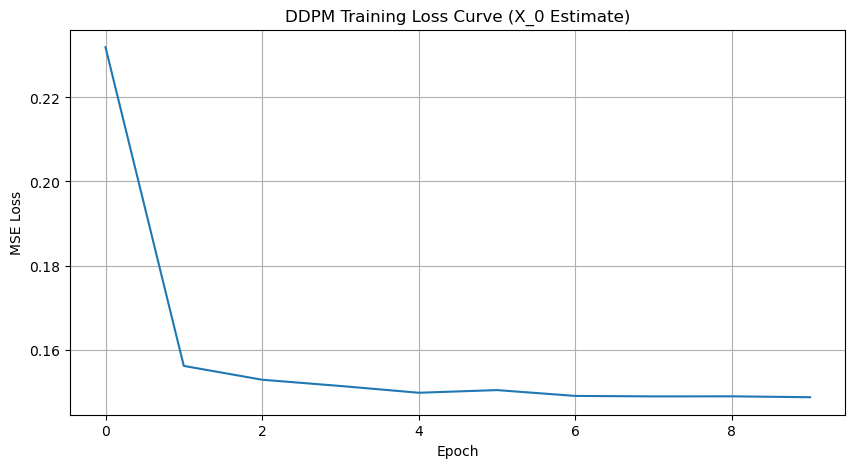

Epoch 11/50: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]


Epoch 11, Average Loss: 0.1480


Epoch 12/50: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]


Epoch 12, Average Loss: 0.1479


Epoch 13/50: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]


Epoch 13, Average Loss: 0.1473


Epoch 14/50: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]


Epoch 14, Average Loss: 0.1473


Epoch 15/50: 100%|██████████| 469/469 [00:21<00:00, 21.65it/s]


Epoch 15, Average Loss: 0.1468


Epoch 16/50: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]


Epoch 16, Average Loss: 0.1478


Epoch 17/50: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]


Epoch 17, Average Loss: 0.1471


Epoch 18/50: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]


Epoch 18, Average Loss: 0.1488


Epoch 19/50: 100%|██████████| 469/469 [00:21<00:00, 21.67it/s]


Epoch 19, Average Loss: 0.1467


Epoch 20/50: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]


Epoch 20, Average Loss: 0.1469


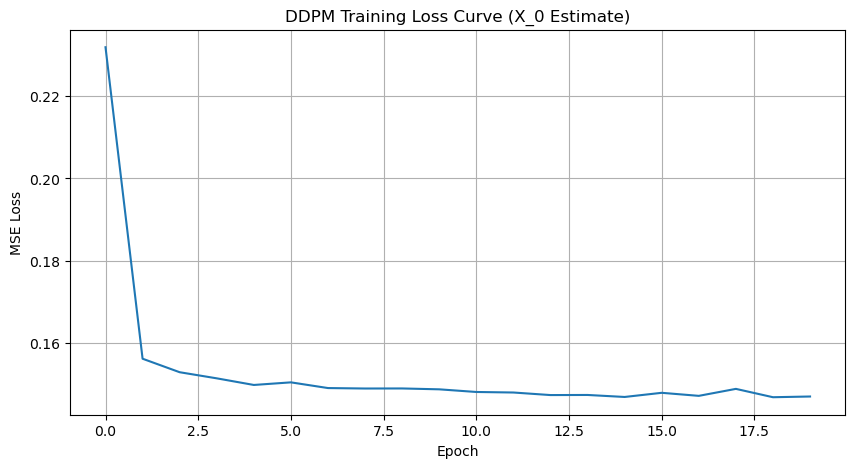

Epoch 21/50: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]


Epoch 21, Average Loss: 0.1460


Epoch 22/50: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]


Epoch 22, Average Loss: 0.1476


Epoch 23/50: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]


Epoch 23, Average Loss: 0.1470


Epoch 24/50: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]


Epoch 24, Average Loss: 0.1466


Epoch 25/50: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]


Epoch 25, Average Loss: 0.1458


Epoch 26/50: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]


Epoch 26, Average Loss: 0.1464


Epoch 27/50: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]


Epoch 27, Average Loss: 0.1457


Epoch 28/50: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]


Epoch 28, Average Loss: 0.1455


Epoch 29/50: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]


Epoch 29, Average Loss: 0.1460


Epoch 30/50: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]


Epoch 30, Average Loss: 0.1460


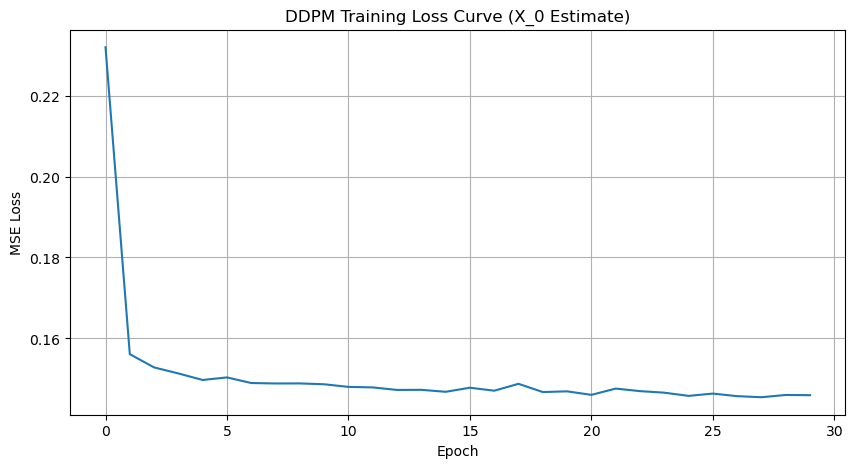

Epoch 31/50: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]


Epoch 31, Average Loss: 0.1465


Epoch 32/50: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]


Epoch 32, Average Loss: 0.1457


Epoch 33/50: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]


Epoch 33, Average Loss: 0.1456


Epoch 34/50: 100%|██████████| 469/469 [00:21<00:00, 21.61it/s]


Epoch 34, Average Loss: 0.1455


Epoch 35/50: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]


Epoch 35, Average Loss: 0.1456


Epoch 36/50: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]


Epoch 36, Average Loss: 0.1456


Epoch 37/50: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]


Epoch 37, Average Loss: 0.1447


Epoch 38/50: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]


Epoch 38, Average Loss: 0.1456


Epoch 39/50: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]


Epoch 39, Average Loss: 0.1454


Epoch 40/50: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]


Epoch 40, Average Loss: 0.1457


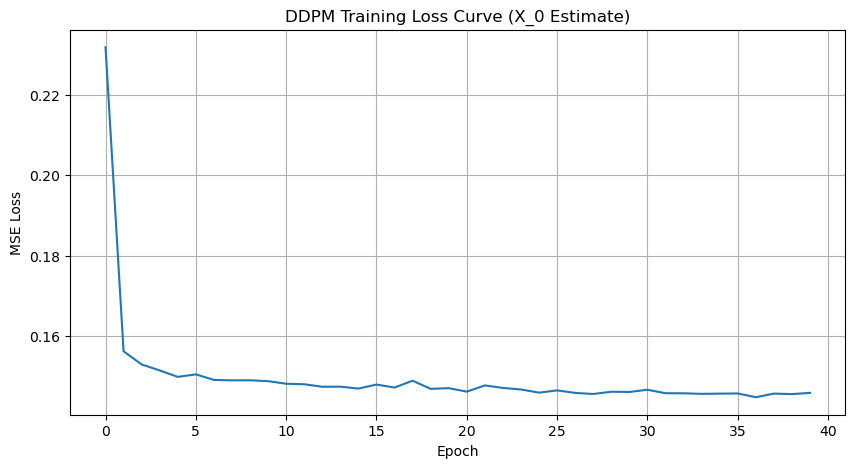

Epoch 41/50: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]


Epoch 41, Average Loss: 0.1450


Epoch 42/50: 100%|██████████| 469/469 [00:21<00:00, 21.78it/s]


Epoch 42, Average Loss: 0.1449


Epoch 43/50: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]


Epoch 43, Average Loss: 0.1457


Epoch 44/50: 100%|██████████| 469/469 [00:21<00:00, 21.78it/s]


Epoch 44, Average Loss: 0.1454


Epoch 45/50: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]


Epoch 45, Average Loss: 0.1446


Epoch 46/50: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]


Epoch 46, Average Loss: 0.1455


Epoch 47/50: 100%|██████████| 469/469 [00:21<00:00, 21.78it/s]


Epoch 47, Average Loss: 0.1442


Epoch 48/50: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]


Epoch 48, Average Loss: 0.1453


Epoch 49/50: 100%|██████████| 469/469 [00:21<00:00, 21.78it/s]


Epoch 49, Average Loss: 0.1453


Epoch 50/50: 100%|██████████| 469/469 [00:21<00:00, 21.88it/s]


Epoch 50, Average Loss: 0.1455


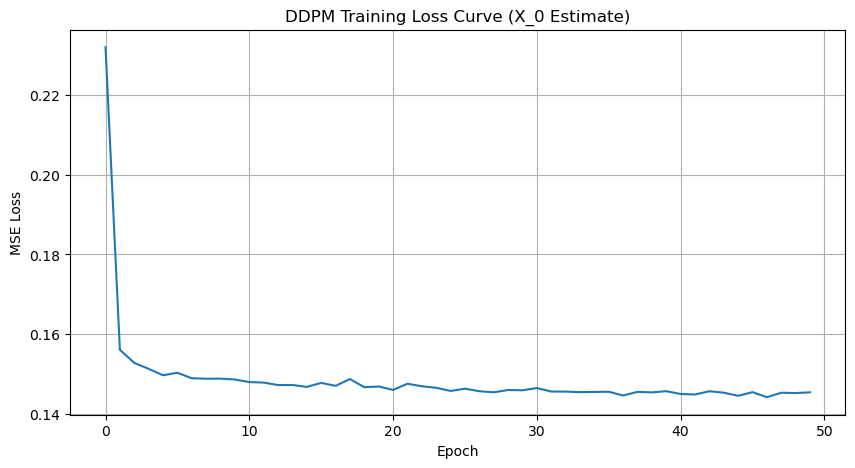

Generating new images (using X_0 estimates for reverse process)...


Sampling: 100%|██████████| 1000/1000 [00:04<00:00, 220.25it/s]


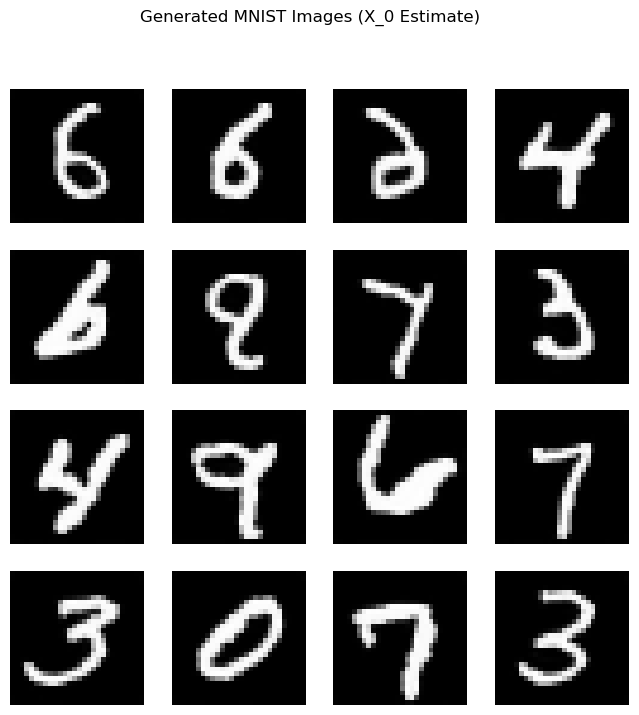

Training and sampling complete!


In [5]:
# --- 5. Training Loop ---
if __name__ == "__main__":
    unet_model = UNet(in_channels=1, out_channels=1, time_emb_dim=256)
    ddpm = DDPM(unet_model, timesteps=TIMESTEPS, device=DEVICE)
    optimizer = optim.Adam(ddpm.model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss() # Standard MSELoss is used for x_0 prediction

    train_losses = []

    print(f"Training on {DEVICE} with X_0 Estimation")
    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0
        for batch_idx, (images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")):
            images = images.to(DEVICE) # This is our true x_0
            
            t = ddpm.sample_timesteps(images.shape[0])

            # Forward diffusion gets us x_t (noisy image)
            x_t, _ = ddpm.forward_diffusion(images, t) # We don't need true_noise for this objective

            # The U-Net predicts the clean image x_0
            predicted_x0 = ddpm.model(x_t, t)

            # The loss is between the predicted x_0 and the true x_0
            loss = criterion(predicted_x0, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch+1}, Average Loss: {avg_epoch_loss:.4f}")

        if (epoch + 1) % 10 == 0 or epoch == NUM_EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses)
            plt.title("DDPM Training Loss Curve (X_0 Estimate)")
            plt.xlabel("Epoch")
            plt.ylabel("MSE Loss")
            plt.grid(True)
            plt.show()

    print("Generating new images (using X_0 estimates for reverse process)...")
    num_samples_to_generate = 16
    sampled_images = ddpm.sample(num_samples_to_generate, channels=1, img_size=IMG_SIZE)

    plt.figure(figsize=(8, 8))
    for i in range(num_samples_to_generate):
        plt.subplot(int(np.sqrt(num_samples_to_generate)), int(np.sqrt(num_samples_to_generate)), i + 1)
        plt.imshow(sampled_images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle("Generated MNIST Images (X_0 Estimate)")
    plt.show()

    print("Training and sampling complete!")